<a href="https://colab.research.google.com/github/BrunoBVR/DL-with-python/blob/main/5p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a convnet from scratch on a small dataset

Classifying Dogs vs. Cats images.

---

# Using a pretrained convnet

## Feature extraction

> Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

## Using the **VGG16** model

In [3]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,  # Using the base
                  input_shape = (150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


* *weights* specifies the weight checkpoint from which to initialize the model.
* *include_top* refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with only two classes: cat and dog ), you don’t need to include it.
*  *input_shape* is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to
process inputs of any size.

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

Recording the output of `conv_base` on your data and using these outputs as inputs to a new model.

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/DL-With-Python/Chapter5/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels
  
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512) . You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192) :

In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### Defining and training the densely connected classifier

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.5781 - acc: 0.6895 - val_loss: 0.4393 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4182 - acc: 0.8105 - val_loss: 0.3708 - val_acc: 0.8470
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3553 - acc: 0.8455 - val_loss: 0.3250 - val_acc: 0.8730
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3176 - acc: 0.8620 - val_loss: 0.3024 - val_acc: 0.8870
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2894 - acc: 0.8790 - val_loss: 0.2876 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2648 - acc: 0.8965 - val_loss: 0.2942 - val_acc: 0.8790
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2514 - acc: 0.8975 - val_loss: 0.2728 - val_acc: 0.8900
Epoch 8/30
100/100 [==============================] - 1s 6ms/step - loss: 0.

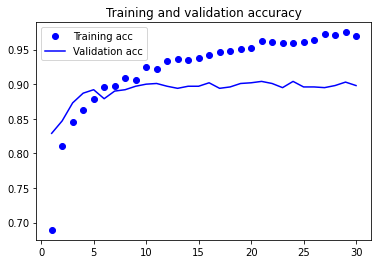

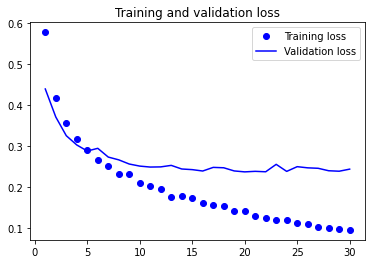

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()